In [1]:
import pandas as pd
import os
from glob import glob
import re
path = r"C:\Users\sachi\Documents\Researchcode\master_combined_risk"
csv_files = glob(os.path.join(path, "*.csv"))
combined_dfs = []
for file in csv_files:
    filename = os.path.basename(file).replace(".csv", "")
    lag_match = re.search(r'_(\d+)_', filename)
    Type = filename.strip().split('_')[-1]
    lag = int(lag_match.group(1)) if lag_match else None    
    df = pd.read_csv(file)
    df['lag'] = lag
    df['Type'] = Type
    combined_dfs.append(df)
df = pd.concat(combined_dfs, ignore_index=True)
df.rename(columns = {'Unnamed: 0':'Ticker'}, inplace = True)
def filter_df(lag,ticker,df):
    df = df[df['lag'] == lag]
    df = df[df['Ticker'] == str(ticker)]

    return df
data = filter_df(5,'SPY',df)


In [2]:
data = data[['Ticker','Model', 'Accuracy_x', 'Confusion Matrix_x','Return [%]_x','Buy & Hold Return [%]_x','Return [%]_y', 'Type']]
data.reset_index(inplace = True,drop = True)
data.loc[12,'Accuracy_x'] = 1
data.loc[25,'Accuracy_x'] = 1
data.loc[38,'Accuracy_x'] = 1
data.loc[12,'Confusion Matrix_x'] = 1
data.loc[25,'Confusion Matrix_x'] = 1
data.loc[38,'Confusion Matrix_x'] = 1


def get_metrics(data):
    def extract_matrix_values(matrix_str):
        matrix_str = str(matrix_str)
        numbers = re.findall(r'\d+', matrix_str)
        if len(numbers) < 4:
            return pd.Series({'TN': 1, 'FP': 1, 'FN': 1, 'TP': 1})
        
        numbers = [int(x) for x in numbers]
        
        return pd.Series({
            'TN': numbers[0],
            'FP': numbers[1],
            'FN': numbers[2],
            'TP': numbers[3]
        })
    new_columns = data['Confusion Matrix_x'].apply(extract_matrix_values)
    data[['TN', 'FP', 'FN', 'TP']] = new_columns
    
    def calculate_metrics(row):
        tp = row.get('TP', 0)
        fp = row.get('FP', 0)
        fn = row.get('FN', 0)
        tn = row.get('TN', 0)

        precision = tp / (tp + fp) if (tp + fp) != 0 else 0
        tpr = tp / (tp + fn) if (tp + fn) != 0 else 0  # True Positive Rate (Recall)
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # False Positive Rate

        return pd.Series({
            'Precision': precision,
            'TPR': tpr,         
            'FPR': fpr
        })

    
    metrics = data.apply(calculate_metrics, axis=1)
    data = pd.concat([data, metrics], axis=1)
    data.drop(columns = ['Confusion Matrix_x'],inplace = True)
    return data

data = get_metrics(data)

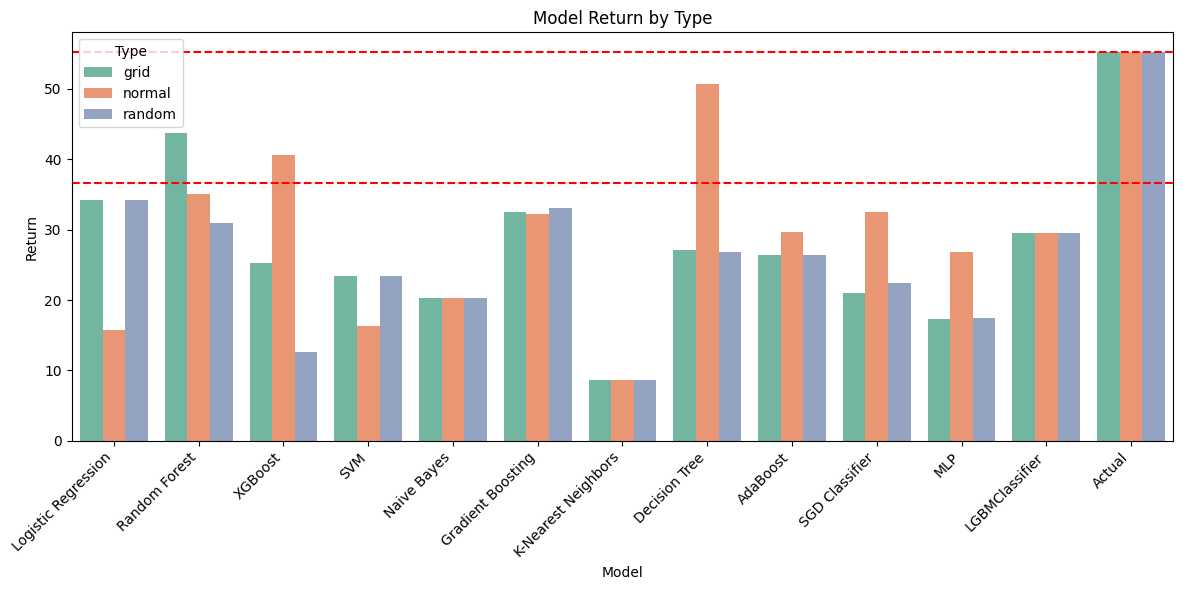

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting using seaborn barplot
plt.figure(figsize=(12, 6))

# Create a barplot for Accuracy, grouped by Type and showing each Model
sns.barplot(data=data, x="Model", y="Return [%]_x", hue="Type", palette="Set2")

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.axhline(y=data['Buy & Hold Return [%]_x'].mean(), color='r', linestyle='--', label='Buy & Hold Return [%]')
plt.axhline(y=data['Return [%]_x'].loc[12], color='r', linestyle='--', label='Actual')
# Adding labels and title
plt.xlabel('Model')
plt.ylabel('Return')
plt.title('Model Return by Type')

# Show the plot
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap of Metrics')

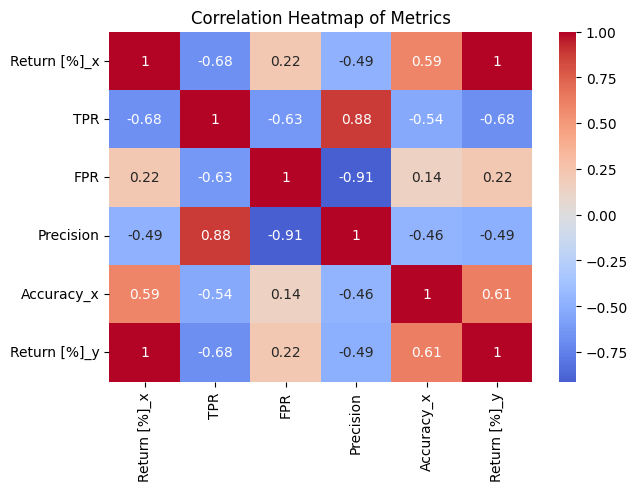

In [4]:
# Calculate correlations
metrics = ['Return [%]_x', 'TPR', 'FPR', 'Precision', 'Accuracy_x','Return [%]_y']
correlation_matrix = data[metrics].corr()

# Create visualizations
plt.figure(figsize=(15, 10))

# 1. Correlation Heatmap
plt.subplot(2, 2, 1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Metrics')




Text(0.5, 1.0, 'Covariance Heatmap of Metrics')

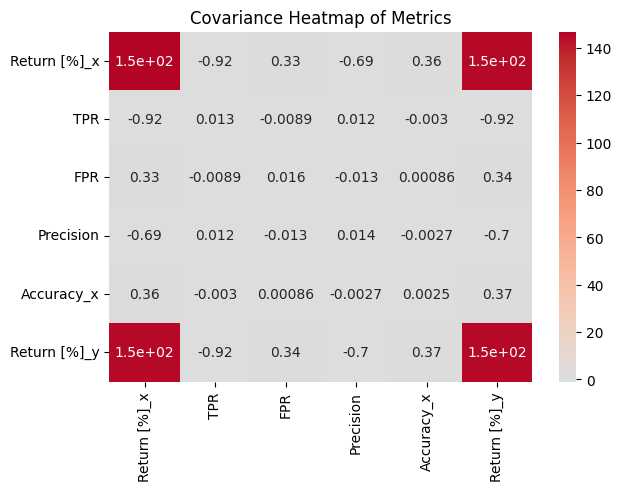

In [5]:
# Calculate correlations
metrics = ['Return [%]_x', 'TPR', 'FPR', 'Precision', 'Accuracy_x','Return [%]_y']
correlation_matrix = data[metrics].cov()

# Create visualizations
plt.figure(figsize=(15, 10))

# 1. Correlation Heatmap
plt.subplot(2, 2, 1)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Covariance Heatmap of Metrics')




Text(0, 0.5, 'Return %')

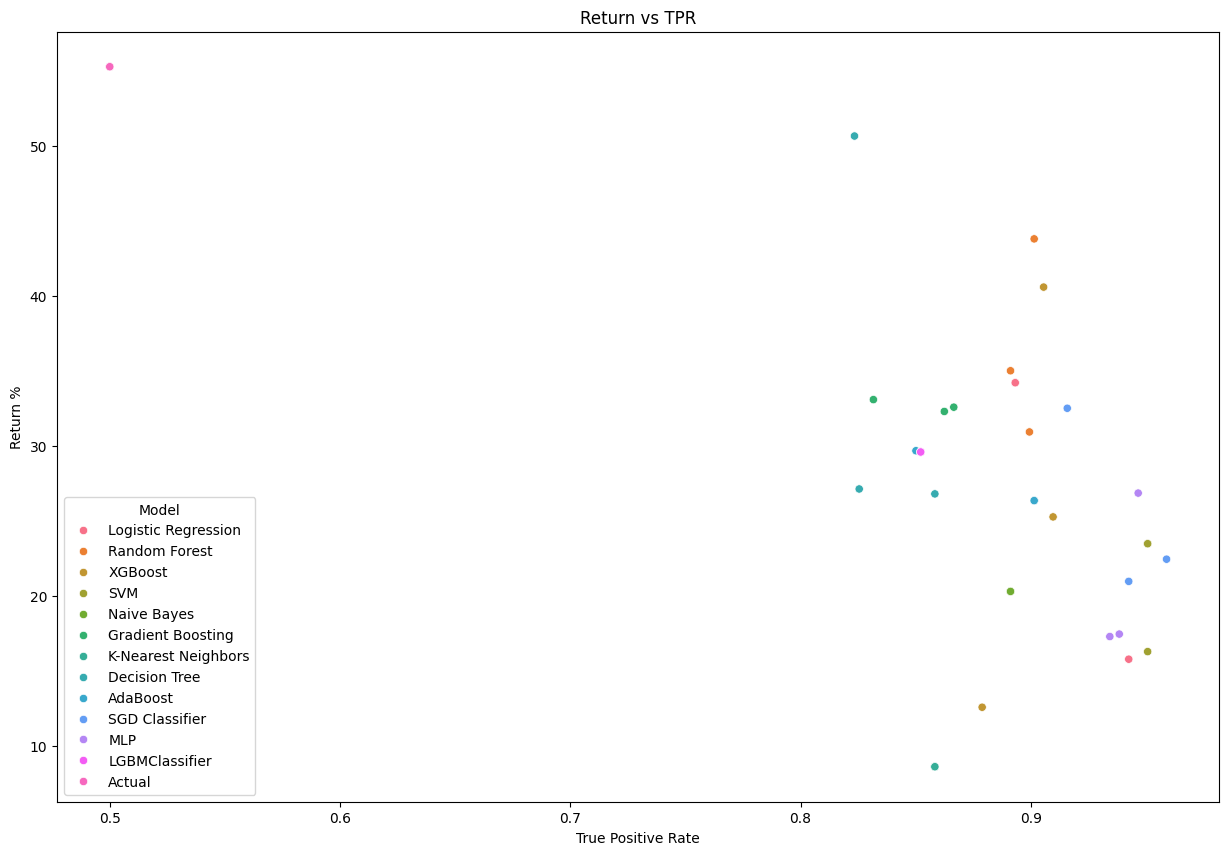

In [6]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=data, x='TPR', y='Return [%]_x',hue = 'Model')
plt.title('Return vs TPR')
plt.xlabel('True Positive Rate')
plt.ylabel('Return %')

Text(0, 0.5, 'Return %')

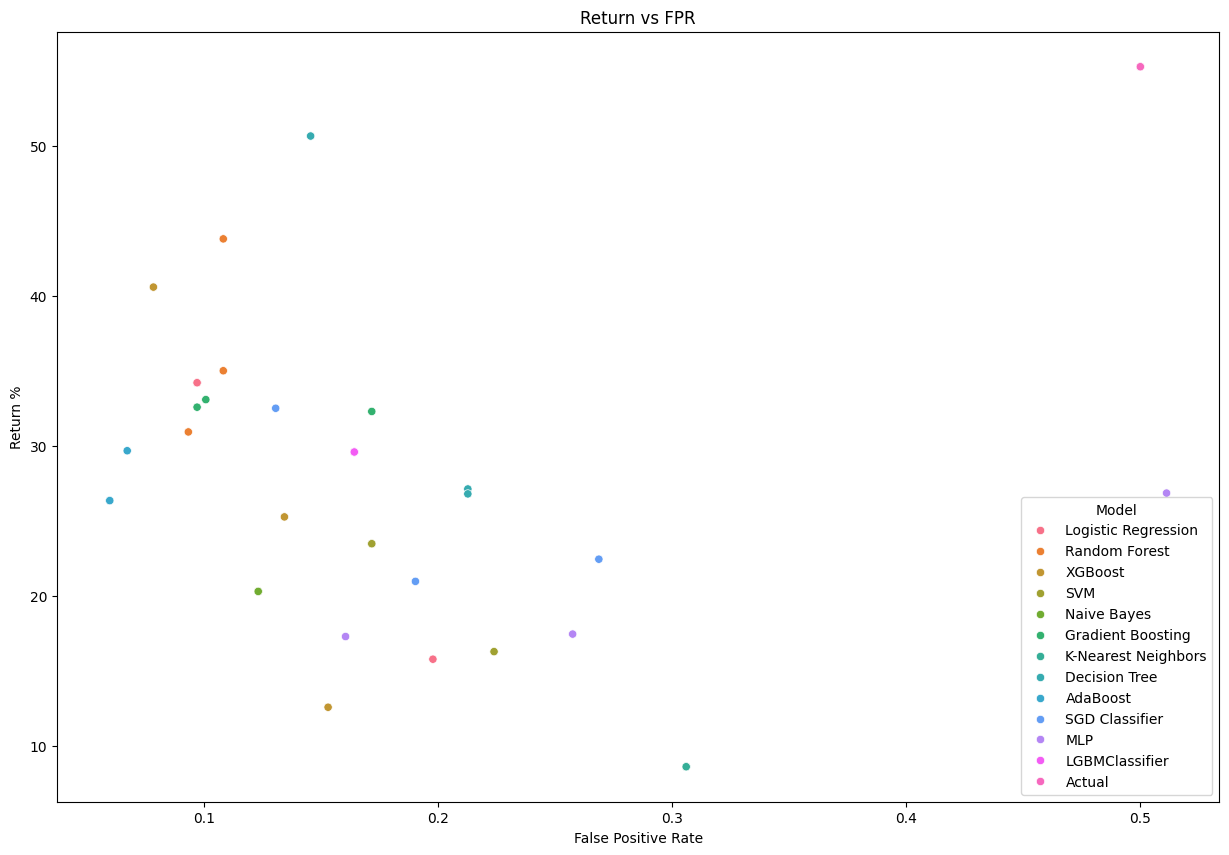

In [7]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=data, x='FPR', y='Return [%]_x', hue='Model')
plt.title('Return vs FPR')
plt.xlabel('False Positive Rate')
plt.ylabel('Return %')

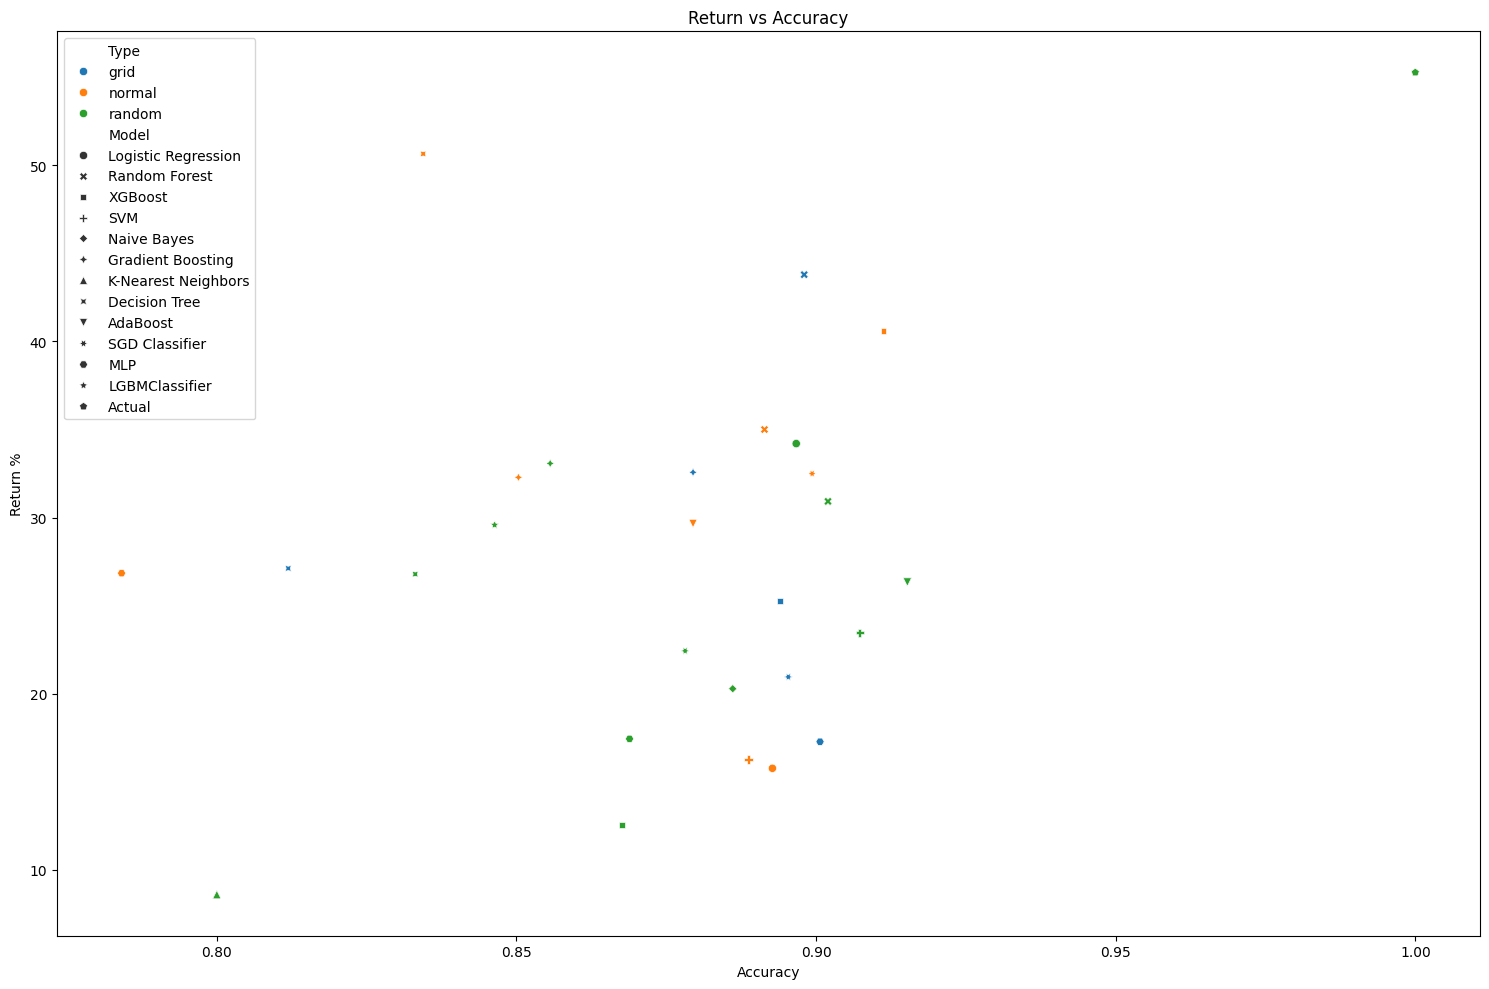

In [8]:
plt.figure(figsize=(15, 10))
sns.scatterplot(data=data, x='Accuracy_x', y='Return [%]_x', hue='Type', style='Model')
plt.title('Return vs Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Return %')

plt.tight_layout()
plt.show()


In [9]:
data.sort_values('Return [%]_x',ascending = False)

,Ticker,Model,Accuracy_x,Return [%]_x,Buy & Hold Return [%]_x,Return [%]_y,Type,TN,FP,FN,TP,Precision,TPR,FPR
38,SPY,Actual,1.000000,55.272000,36.59818,55.272000,random,1,1,1,1,0.500000,0.500000,0.500000
25,SPY,Actual,1.000000,55.272000,36.59818,55.272000,normal,1,1,1,1,0.500000,0.500000,0.500000
12,SPY,Actual,1.000000,55.272000,36.59818,55.272000,grid,1,1,1,1,0.500000,0.500000,0.500000
20,SPY,Decision Tree,0.834437,50.649679,36.59818,50.846173,normal,229,39,86,401,0.911364,0.823409,0.145522
1,SPY,Random Forest,0.898013,43.790292,36.59818,43.790292,grid,239,29,48,439,0.938034,0.901437,0.108209
15,SPY,XGBoost,0.911258,40.574894,36.59818,40.576894,normal,247,21,46,441,0.954545,0.905544,0.078358
14,SPY,Random Forest,0.891391,34.994895,36.59818,33.214795,normal,239,29,53,434,0.937365,0.891170,0.108209
26,SPY,Logistic Regression,0.896689,34.197395,36.59818,34.197395,random,242,26,52,435,0.943601,0.893224,0.097015
0,SPY,Logistic Regression,0.896689,34.197395,36.59818,34.197395,grid,242,26,52,435,0.943601,0.893224,0.097015
31,SPY,Gradient Boosting,0.855629,33.070884,36.59818,31.733893,random,241,27,82,405,0.937500,0.831622,0.100746


In [10]:
results = []

for ticker in df.Model.unique():
    log_model = df[df.Model == ticker]
    for t in df.Type.unique():
        norm_log = log_model[log_model.Type == t]
        for l in norm_log.lag.unique():
            data = norm_log[norm_log['lag'] == l]
            total_return = data['Return [%]_x'].sum()
            total_bh_return = data['Buy & Hold Return [%]_x'].sum()

            results.append({
                'Model': ticker,
                'Type': t,
                'lag': l,
                'Total Strategy Return [%]': total_return,
                'Total Buy & Hold Return [%]': total_bh_return
            })

# Convert list of dictionaries into DataFrame
summary_df = pd.DataFrame(results)
print(summary_df)


                   Model    Type  lag  Total Strategy Return [%]  \
0    Logistic Regression    grid    0                 808.980941   
1    Logistic Regression    grid   10                 799.762347   
2    Logistic Regression    grid   15                 826.822028   
3    Logistic Regression    grid   20                 841.142841   
4    Logistic Regression    grid   25                 800.643799   
..                   ...     ...  ...                        ...   
502               Actual  random   45                2137.606412   
503               Actual  random   50                2137.606412   
504               Actual  random   55                2077.840635   
505               Actual  random    5                2085.038914   
506               Actual  random   60                2071.299066   

     Total Buy & Hold Return [%]  
0                     969.430951  
1                     913.855285  
2                     948.224642  
3                     915.385676  
4       

In [11]:
pd.set_option('display.max_rows',None)

In [12]:
summary_df.sort_values('Total Strategy Return [%]',ascending = False)

,Model,Type,lag,Total Strategy Return [%],Total Buy & Hold Return [%]
481,Actual,normal,0,2172.412945,969.430951
494,Actual,random,0,2172.412945,969.430951
468,Actual,grid,0,2172.412945,969.430951
488,Actual,normal,40,2137.606412,1025.845914
477,Actual,grid,50,2137.606412,1041.505195
490,Actual,normal,50,2137.606412,1041.505195
487,Actual,normal,35,2137.606412,1004.916874
485,Actual,normal,25,2137.606412,999.096218
486,Actual,normal,30,2137.606412,1104.955599
475,Actual,grid,40,2137.606412,1025.845914


In [13]:
data = df[df['Model']!= 'Actual']

In [14]:
data.isnull().sum()

Ticker                       0
Unnamed: 1                   0
Model                        0
Accuracy_x                   0
Confusion Matrix_x           0
Start_x                      0
End_x                        0
Duration_x                   0
Exposure Time [%]_x          0
Equity Final [$]_x           0
Equity Peak [$]_x            0
Return [%]_x                 0
Buy & Hold Return [%]_x      0
Return (Ann.) [%]_x          0
Volatility (Ann.) [%]_x      0
CAGR [%]_x                   0
Sharpe Ratio_x              15
Sortino Ratio_x             15
Calmar Ratio_x              15
Alpha [%]_x                  0
Beta_x                       0
Max. Drawdown [%]_x          0
Avg. Drawdown [%]_x         15
Max. Drawdown Duration_x    15
Avg. Drawdown Duration_x    15
# Trades_x                   0
Win Rate [%]_x              51
Best Trade [%]_x            51
Worst Trade [%]_x           51
Avg. Trade [%]_x            51
Max. Trade Duration_x       51
Avg. Trade Duration_x       51
Profit F

In [15]:
data = data[['Ticker','Model', 'Accuracy_x', 'Confusion Matrix_x','Return [%]_x','Buy & Hold Return [%]_x','Return [%]_y', 'Type','lag']]


In [16]:
data = get_metrics(data)
data = data[data['lag'] != 0]
data = data[data['FP'] != 0]
data = data[data['FN'] != 0]
data = data[data['TP'] != 0]
data = data[data['TN'] != 0]

In [17]:
data.groupby('Model')['Return [%]_x'].sum()

Model
AdaBoost               22499.769592
Decision Tree          25599.861618
Gradient Boosting      25093.472241
K-Nearest Neighbors    19805.183554
LGBMClassifier         24555.548746
Logistic Regression    27843.792160
MLP                    23050.342851
Naive Bayes            21893.711004
Random Forest          25086.522624
SGD Classifier         22846.157363
SVM                    22512.075335
XGBoost                23422.825891
Name: Return [%]_x, dtype: float64

In [18]:
data.columns

Index(['Ticker', 'Model', 'Accuracy_x', 'Return [%]_x',
       'Buy & Hold Return [%]_x', 'Return [%]_y', 'Type', 'lag', 'TN', 'FP',
       'FN', 'TP', 'Precision', 'TPR', 'FPR'],
      dtype='object')

In [19]:
mean_d = data.groupby(['lag','Model','Ticker'])[['Return [%]_x', 'Buy & Hold Return [%]_x']].mean()


<Axes: xlabel='Ticker'>

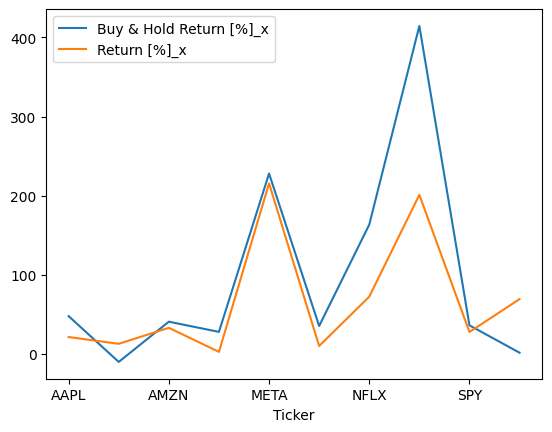

In [20]:
data.groupby('Ticker')[['Buy & Hold Return [%]_x', 'Return [%]_x']].mean().plot()


In [21]:
mean_d.T

lag                             5                                    \
Model                     AdaBoost                                    
Ticker                        AAPL        AMD       AMZN      GOOGL   
Return [%]_x             13.018514  10.668471  69.857445  -4.758321   
Buy & Hold Return [%]_x  45.815408 -14.664264  37.911444  26.986764   

lag                                                                     \
Model                                                                    
Ticker                         META       MSFT        NFLX        NVDA   
Return [%]_x             248.565334  10.895089  109.473959  187.203537   
Buy & Hold Return [%]_x  217.071277  33.246208  146.922034  405.937366   

lag                                            ...         60             \
Model                                          ...    XGBoost              
Ticker                         SPY       TSLA  ...       AAPL        AMD   
Return [%]_x             27.443901  10.583596  ...  19.344375  10.680735   
Buy & Hold Return [%]_x  36.598180   5.629584  ...  44.712775 -12.295079   

lag                                                                  \
Model                                                                 
Ticker                        AMZN     GOOGL        META       MSFT   
Return [%]_x             44.429791  14.10889  204.582295  15.577814   
Buy & Hold Return [%]_x  29.450762  23.78283  204.050983  30.656062   

lag                                                                    
Model                                                                  
Ticker                         NFLX        NVDA        SPY       TSLA  
Return [%]_x              55.145756  181.629314  40.350195  68.275506  
Buy & Hold Return [%]_x  153.039935  354.201813  31.613876  -6.576166  

[2 rows x 1416 columns]

In [22]:
pd.set_option('display.max_columns',None)

In [23]:
mean_d.T[0]

KeyError: 0

In [ ]:
mean_d.T[5]

Model                     AdaBoost                                   \
Ticker                        AAPL        AMD       AMZN      GOOGL   
Return [%]_x             13.018514  10.668471  69.857445  -4.758321   
Buy & Hold Return [%]_x  45.815408 -14.664264  37.911444  26.986764   

Model                                                                   \
Ticker                         META       MSFT        NFLX        NVDA   
Return [%]_x             248.565334  10.895089  109.473959  187.203537   
Buy & Hold Return [%]_x  217.071277  33.246208  146.922034  405.937366   

Model                                         Decision Tree             \
Ticker                         SPY       TSLA          AAPL        AMD   
Return [%]_x             27.443901  10.583596     29.234863   8.812625   
Buy & Hold Return [%]_x  36.598180   5.629584     45.815408 -14.664264   

Model                                                                 \
Ticker                        AMZN      GOOGL        META       MSFT   
Return [%]_x             26.280150  -7.418851  196.376777   7.985572   
Buy & Hold Return [%]_x  37.911444  26.986764  217.071277  33.246208   

Model                                                                   \
Ticker                         NFLX        NVDA        SPY        TSLA   
Return [%]_x              63.436027  188.523431  34.847616  218.544266   
Buy & Hold Return [%]_x  146.922034  405.937366  36.598180    5.629584   

Model                   Gradient Boosting                                   \
Ticker                               AAPL        AMD       AMZN      GOOGL   
Return [%]_x                    26.498594   6.507585  14.395397   4.968793   
Buy & Hold Return [%]_x         45.815408 -14.664264  37.911444  26.986764   

Model                                                                   \
Ticker                         META       MSFT        NFLX        NVDA   
Return [%]_x             183.190618  19.733325   74.865710  199.989063   
Buy & Hold Return [%]_x  217.071277  33.246208  146.922034  405.937366   

Model                                         K-Nearest Neighbors             \
Ticker                         SPY       TSLA                AAPL        AMD   
Return [%]_x             32.639117  81.519377           13.085766 -28.594215   
Buy & Hold Return [%]_x  36.598180   5.629584           45.815408 -14.664264   

Model                                                                 \
Ticker                        AMZN      GOOGL        META       MSFT   
Return [%]_x             45.124194  -3.030506  166.974319  24.405314   
Buy & Hold Return [%]_x  37.911444  26.986764  217.071277  33.246208   

Model                                                                  \
Ticker                         NFLX        NVDA        SPY       TSLA   
Return [%]_x              65.116688  120.699709   8.586575  37.779400   
Buy & Hold Return [%]_x  146.922034  405.937366  36.598180   5.629584   

Model                   LGBMClassifier                                   \
Ticker                            AAPL        AMD       AMZN      GOOGL   
Return [%]_x                 17.614486  16.804800  38.858204  20.491375   
Buy & Hold Return [%]_x      45.815408 -14.664264  37.911444  26.986764   

Model                                                                   \
Ticker                         META       MSFT        NFLX        NVDA   
Return [%]_x             220.853323  13.586506   30.697218  220.937196   
Buy & Hold Return [%]_x  217.071277  33.246208  146.922034  405.937366   

Model                                          Logistic Regression             \
Ticker                         SPY        TSLA                AAPL        AMD   
Return [%]_x             29.576703  143.920407           23.417716  15.822530   
Buy & Hold Return [%]_x  36.598180    5.629584           45.815408 -14.664264   

Model                                                                 \
Ticker                     

In [ ]:
mean_d.T[20]['AdaBoost'].T

,Return [%]_x,Buy & Hold Return [%]_x
Ticker,,
AAPL,10.223650,42.471185
AMD,12.098836,-15.869121
AMZN,78.321563,37.281530
GOOGL,-5.678124,25.212245
META,226.932168,216.294262
MSFT,14.225755,30.760517
NFLX,86.417329,153.419470
NVDA,182.793261,396.077642
SPY,26.990465,33.606606


In [ ]:
data[(data['lag'] == 20) & (data['Model'] == 'AdaBoost')]

,Ticker,Model,Accuracy_x,Return [%]_x,Buy & Hold Return [%]_x,Return [%]_y,Type,lag,TN,FP,FN,TP,Precision,TPR,FPR
1178,AAPL,AdaBoost,0.888149,13.406920,42.471185,11.695714,grid,20,314,43,41,353,0.891414,0.895939,0.120448
1191,AMD,AdaBoost,0.876165,4.600998,-15.869121,13.158005,grid,20,372,51,42,286,0.848665,0.871951,0.120567
1204,AMZN,AdaBoost,0.884154,86.098151,37.281530,75.978870,grid,20,265,20,67,399,0.952267,0.856223,0.070175
1217,GOOGL,AdaBoost,0.886818,-3.578182,25.212245,-3.936395,grid,20,285,41,44,381,0.902844,0.896471,0.125767
1230,META,AdaBoost,0.818908,223.203386,216.294262,216.152772,grid,20,196,52,84,419,0.889597,0.833002,0.209677
1243,MSFT,AdaBoost,0.897470,18.337996,30.760517,17.815896,grid,20,315,20,57,359,0.947230,0.862981,0.059701
1256,NFLX,AdaBoost,0.860186,78.937291,153.419470,74.497789,grid,20,202,48,57,444,0.902439,0.886228,0.192000
1269,NVDA,AdaBoost,0.893475,166.077617,396.077642,138.722356,grid,20,257,45,35,414,0.901961,0.922049,0.149007
1282,SPY,AdaBoost,0.912117,26.837101,33.606606,26.503807,grid,20,248,16,50,437,0.964680,0.897331,0.060606
1295,TSLA,AdaBoost,0.864181,22.985455,-3.868660,8.383537,grid,20,368,58,44,281,0.828909,0.864615,0.136150


In [ ]:
# Adjust layout with more space between subplots
plt.tight_layout(h_pad=2, w_pad=5)
plt.show()


<Figure size 640x480 with 0 Axes>

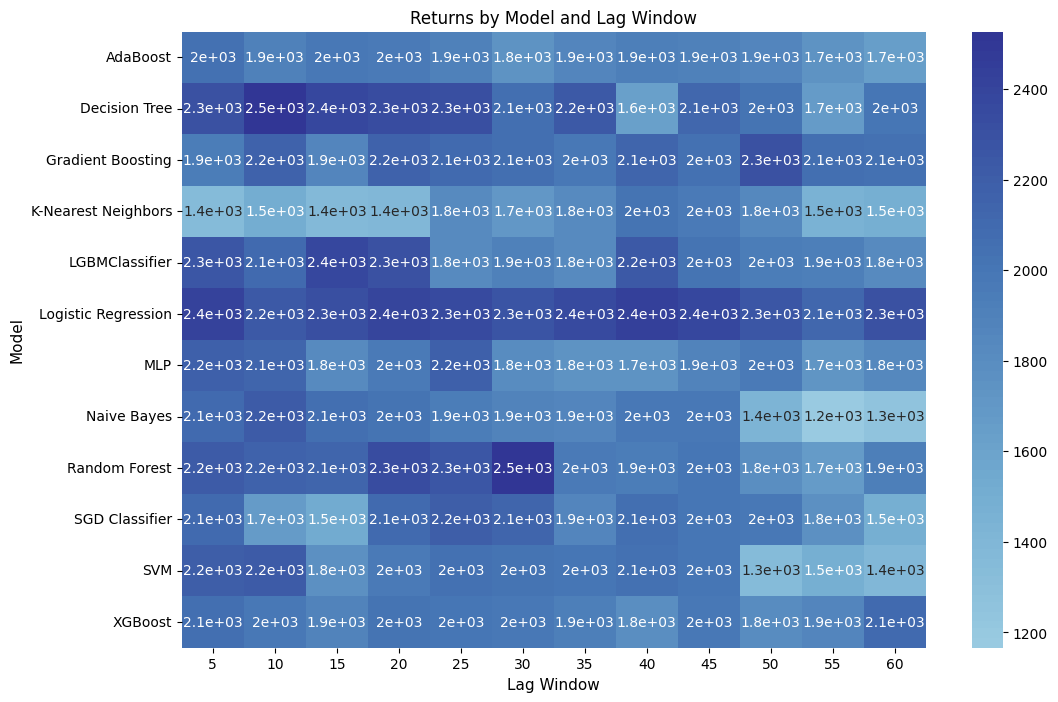

In [ ]:
# Alternative heatmap visualization
plt.figure(figsize=(12, 8))
pivot_data = data.pivot_table(
    values='Return [%]_x', 
    index='Model',
    columns='lag',
    aggfunc='sum'
)
sns.heatmap(pivot_data, annot=True, cmap='RdYlBu', center=0)
plt.title('Returns by Model and Lag Window')
plt.xlabel('Lag Window')
plt.ylabel('Model')
plt.show()


In [ ]:
best_models = data.loc[data.groupby('Ticker')['Return [%]_x'].idxmax()]

In [ ]:
best_models

,Ticker,Model,Accuracy_x,Return [%]_x,Buy & Hold Return [%]_x,Return [%]_y,Type,lag,TN,FP,FN,TP,Precision,TPR,FPR
2735,AAPL,Gradient Boosting,0.763758,59.149417,49.697197,59.204817,grid,40,206,145,31,363,0.714567,0.921320,0.413105
933,AMD,MLP,0.844415,108.920508,-12.580163,71.901396,normal,15,369,54,63,266,0.831250,0.808511,0.127660
1336,AMZN,MLP,0.878828,109.918000,37.281530,92.343584,normal,20,225,60,31,435,0.878788,0.933476,0.210526
439,GOOGL,MLP,0.885942,32.684564,25.316542,22.605272,grid,10,262,67,19,406,0.858351,0.955294,0.203647
4602,META,Logistic Regression,0.814570,374.448071,217.071277,368.180879,random,5,174,78,62,441,0.849711,0.876740,0.309524
846,MSFT,Random Forest,0.678191,57.107556,33.083568,57.642849,grid,15,334,2,240,176,0.988764,0.423077,0.005952
2812,NFLX,Naive Bayes,0.708725,136.442228,169.941429,105.512831,grid,40,176,70,147,352,0.834123,0.705411,0.284553
4391,NVDA,MLP,0.850331,406.768424,405.937366,401.209329,grid,5,292,14,99,350,0.961538,0.779510,0.045752
1021,SPY,Decision Tree,0.836436,59.957582,36.064462,56.876181,normal,15,229,36,87,400,0.917431,0.821355,0.135849
4414,TSLA,Decision Tree,0.896689,263.155551,5.629584,198.593252,grid,5,385,45,33,292,0.866469,0.898462,0.104651


In [ ]:
best_models = data.loc[data.groupby('Ticker')['FPR'].idxmin()]

In [ ]:
best_models

,Ticker,Model,Accuracy_x,Return [%]_x,Buy & Hold Return [%]_x,Return [%]_y,Type,lag,TN,FP,FN,TP,Precision,TPR,FPR
1049,AAPL,SGD Classifier,0.871011,35.931200,45.404416,40.199998,random,15,351,7,90,304,0.977492,0.771574,0.019553
3137,AMD,Naive Bayes,0.749664,23.875701,-2.679705,32.662705,grid,45,414,2,184,143,0.986207,0.437309,0.004808
810,AMZN,Naive Bayes,0.743351,27.376652,38.108539,12.660349,grid,15,282,3,190,277,0.989286,0.593148,0.010526
4728,GOOGL,SGD Classifier,0.518268,-10.115698,23.782830,-9.942897,grid,60,312,2,354,71,0.972603,0.167059,0.006369
3441,META,SGD Classifier,0.780619,186.732484,252.697837,179.336791,random,45,231,9,154,349,0.974860,0.693837,0.037500
1764,MSFT,SGD Classifier,0.798398,2.099294,35.420554,-0.486411,normal,25,332,1,150,266,0.996255,0.639423,0.003003
598,NFLX,Logistic Regression,0.867374,70.851010,146.435526,80.824915,normal,10,231,19,81,423,0.957014,0.839286,0.076000
2700,NVDA,SGD Classifier,0.663539,93.441974,422.073528,87.236830,random,35,296,1,250,199,0.995000,0.443207,0.003367
3618,SPY,Naive Bayes,0.849057,23.400606,37.280890,23.364706,grid,50,247,8,104,383,0.979540,0.786448,0.031373
3896,TSLA,SGD Classifier,0.799191,202.202578,5.482055,190.800500,random,50,409,8,141,184,0.958333,0.566154,0.019185


In [ ]:
data.loc[data.groupby('Model')['Return [%]_y'].idxmax()]

,Ticker,Model,Accuracy_x,Return [%]_x,Buy & Hold Return [%]_x,Return [%]_y,Type,lag,TN,FP,FN,TP,Precision,TPR,FPR
4480,META,AdaBoost,0.846358,257.253139,217.071277,252.415138,normal,5,196,56,60,443,0.887776,0.880716,0.222222
3829,META,Decision Tree,0.809973,313.572507,242.779771,330.207017,random,50,177,62,79,424,0.872428,0.842942,0.259414
486,NVDA,Gradient Boosting,0.881963,285.237794,397.371377,364.368615,grid,10,267,38,51,398,0.912844,0.886414,0.124590
3178,META,K-Nearest Neighbors,0.788694,239.224412,252.697837,251.144441,grid,45,191,49,108,395,0.889640,0.785288,0.204167
1233,META,LGBMClassifier,0.833555,280.981146,216.294262,275.555541,grid,20,190,58,67,436,0.882591,0.866799,0.233871
2821,NVDA,Logistic Regression,0.887248,309.205761,430.276267,394.380499,grid,40,261,35,49,400,0.919540,0.890869,0.118243
4391,NVDA,MLP,0.850331,406.768424,405.937366,401.209329,grid,5,292,14,99,350,0.961538,0.779510,0.045752
3631,TSLA,Naive Bayes,0.811321,131.732559,5.482055,233.333673,grid,50,319,98,42,283,0.742782,0.870769,0.235012
2172,NVDA,Random Forest,0.822193,297.271700,462.710779,326.574506,normal,30,293,6,127,322,0.981707,0.717149,0.020067
620,NVDA,SGD Classifier,0.824934,340.499382,397.371377,364.070114,normal,10,300,5,127,322,0.984709,0.717149,0.016393


In [ ]:
best_models.corr(numeric_only=True)

,Accuracy_x,Return [%]_x,Buy & Hold Return [%]_x,Return [%]_y,lag,TN,FP,FN,TP,Precision,TPR,FPR
Accuracy_x,1.000000,0.246058,-0.074517,0.193736,-0.578048,0.256258,-0.019257,-0.811467,0.465440,-0.036893,0.777425,-0.106831
Return [%]_x,0.246058,1.000000,0.777662,0.988352,-0.514636,0.012041,-0.206162,-0.079903,0.175231,0.216743,0.108909,-0.120103
Buy & Hold Return [%]_x,-0.074517,0.777662,1.000000,0.832491,-0.172138,-0.311653,-0.186644,0.170784,0.244843,0.278012,-0.086131,-0.043200
Return [%]_y,0.193736,0.988352,0.832491,1.000000,-0.502623,-0.067732,-0.198605,-0.040787,0.212952,0.244115,0.078418,-0.098872
lag,-0.578048,-0.514636,-0.172138,-0.502623,1.000000,-0.487936,0.606635,0.117108,0.023188,-0.593268,-0.066221,0.617633
TN,0.256258,0.012041,-0.311653,-0.067732,-0.487936,1.000000,-0.527101,0.097418,-0.735893,0.348422,-0.240333,-0.743330
FP,-0.019257,-0.206162,-0.186644,-0.198605,0.606635,-0.527101,1.000000,-0.568616,0.454884,-0.961817,0.591687,0.949772
FN,-0.811467,-0.079903,0.170784,-0.040787,0.117108,0.097418,-0.568616,1.000000,-0.648824,0.593287,-0.985818,-0.467190
TP,0.465440,0.175231,0.244843,0.212952,0.023188,-0.735893,0.454884,-0.648824,1.000000,-0.327975,0.756523,0.595428
Precision,-0.036893,0.216743,0.278012,0.244115,-0.593268,0.348422,-0.961817,0.593287,-0.327975,1.000000,-0.592691,-0.874418


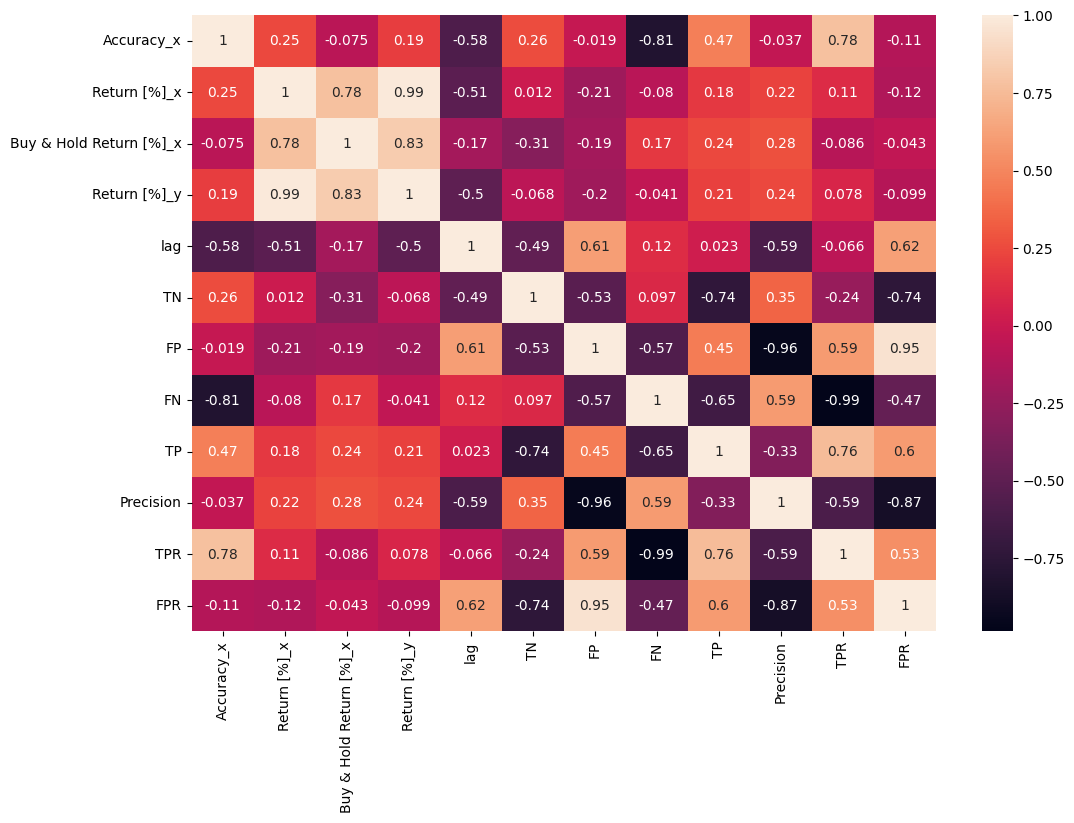

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(best_models.corr(numeric_only=True), annot=True)
plt.show()

In [ ]:
best_models

,Ticker,Model,Accuracy_x,Return [%]_x,Buy & Hold Return [%]_x,Return [%]_y,Type,lag,TN,FP,FN,TP,Precision,TPR,FPR
2735,AAPL,Gradient Boosting,0.763758,59.149417,49.697197,59.204817,grid,40,206,145,31,363,0.714567,0.921320,0.413105
933,AMD,MLP,0.844415,108.920508,-12.580163,71.901396,normal,15,369,54,63,266,0.831250,0.808511,0.127660
1336,AMZN,MLP,0.878828,109.918000,37.281530,92.343584,normal,20,225,60,31,435,0.878788,0.933476,0.210526
439,GOOGL,MLP,0.885942,32.684564,25.316542,22.605272,grid,10,262,67,19,406,0.858351,0.955294,0.203647
4602,META,Logistic Regression,0.814570,374.448071,217.071277,368.180879,random,5,174,78,62,441,0.849711,0.876740,0.309524
846,MSFT,Random Forest,0.678191,57.107556,33.083568,57.642849,grid,15,334,2,240,176,0.988764,0.423077,0.005952
2812,NFLX,Naive Bayes,0.708725,136.442228,169.941429,105.512831,grid,40,176,70,147,352,0.834123,0.705411,0.284553
4391,NVDA,MLP,0.850331,406.768424,405.937366,401.209329,grid,5,292,14,99,350,0.961538,0.779510,0.045752
1021,SPY,Decision Tree,0.836436,59.957582,36.064462,56.876181,normal,15,229,36,87,400,0.917431,0.821355,0.135849
4414,TSLA,Decision Tree,0.896689,263.155551,5.629584,198.593252,grid,5,385,45,33,292,0.866469,0.898462,0.104651


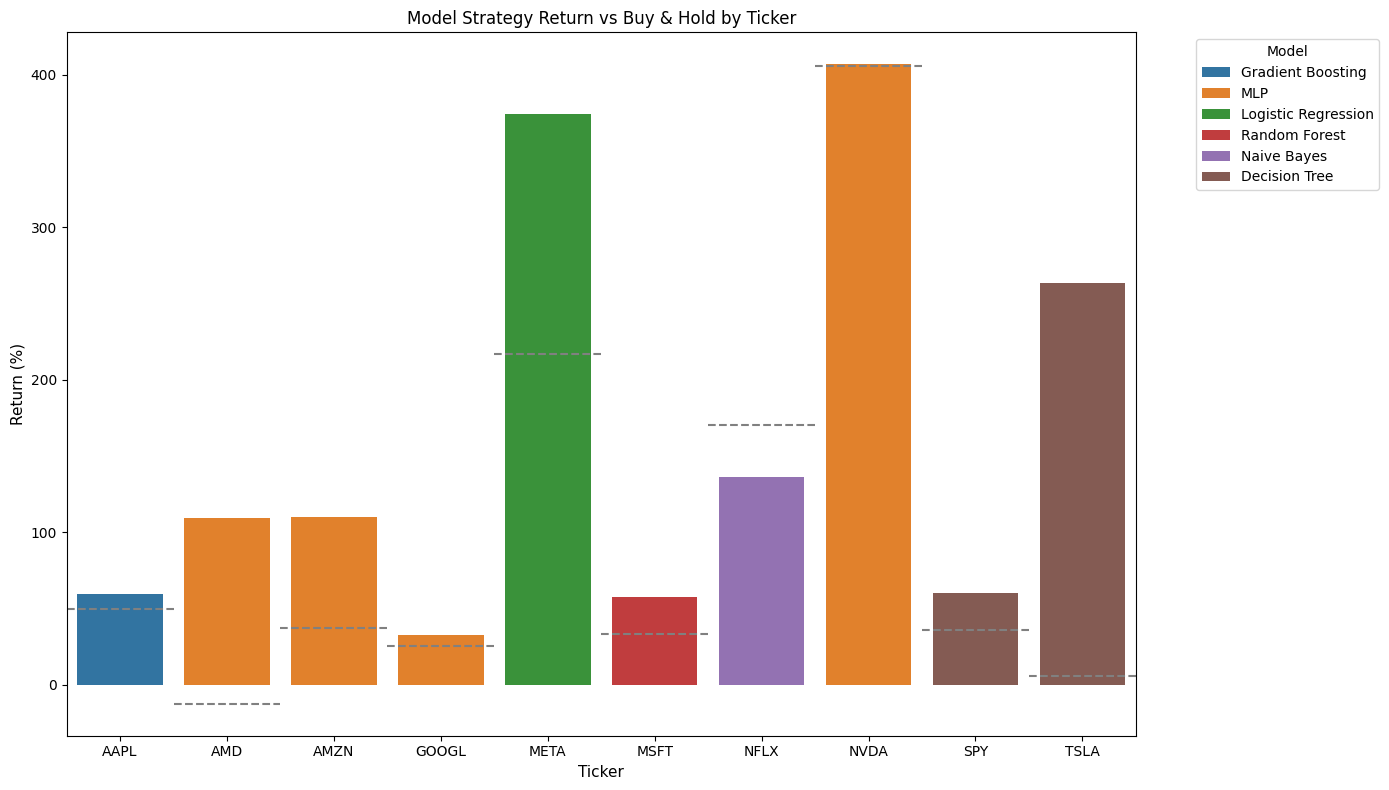

In [ ]:
plt.figure(figsize=(14, 8))

# Plot model strategy returns
sns.barplot(data=best_models, x='Ticker', y='Return [%]_x', hue='Model')

# Plot buy & hold returns as a line for each ticker
for i, ticker in enumerate(best_models['Ticker']):
    bh_return = best_models.loc[best_models['Ticker'] == ticker, 'Buy & Hold Return [%]_x'].values[0]
    plt.axhline(y=bh_return, linestyle='--', color='gray', xmin=i/len(best_models), xmax=(i+1)/len(best_models))

plt.title('Model Strategy Return vs Buy & Hold by Ticker')
plt.ylabel('Return (%)')
plt.xlabel('Ticker')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
best_models['Return [%]_x'].sum()

np.float64(1608.5519006347658)

In [ ]:
best_models['Return [%]_y'].sum()

np.float64(1434.07038980484)

In [ ]:
from models.lag_ml_model import get_data,preprocess_data,classifier_models,train_model,grid_optimize_model,random_optimize_model,get_param_grids
from backtesting import Backtest,Strategy
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\sachi\Documents\Researchcode\research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\sachi\Documents\Researchcode\research\lib\site-packages\backtesting\_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [ ]:
path = r"C:\Users\sachi\Documents\Researchcode\sentiment\merged_data_META_from_2015-01-01_to_2025-03-01.csv"

In [ ]:
from main import backtest_loop,backtest,risk_backtest_loop,risk_backtest,scaling_function,normal_model,random_model,grid_model

In [ ]:
df = get_data(path,ind=True)
X_train,X_test,y_train,y_test = preprocess_data(df,max_lag=5)
X_train_scaled,X_test_scaled = scaling_function(X_train,X_test)
#No Optimation Model
results,y_pred_dict = normal_model(X_train_scaled,X_test_scaled,y_train,y_test)
normal_df,bt_collection = backtest_loop(y_pred_dict,X_test)
risk_df,bt_collection = risk_backtest_loop(y_pred_dict,X_test)
actual,_ = backtest(y_test,X_test)
actual['Model'] = 'Actual'
actual = pd.DataFrame(actual).T
normal_merge = pd.merge(results,normal_df, how='inner')
normal_merge = pd.concat([normal_merge,actual],axis=0)
risk_merge = pd.merge(results,risk_df, how='inner')
risk_merge = pd.concat([risk_merge,actual],axis=0)
normal_merge = pd.merge(normal_merge,risk_merge, on='Model')



Logistic Regression Performance:
Accuracy: 0.8093
Confusion Matrix:
[[167  85]
 [ 59 444]]
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       252
           1       0.84      0.88      0.86       503

    accuracy                           0.81       755
   macro avg       0.79      0.77      0.78       755
weighted avg       0.81      0.81      0.81       755


Random Forest Performance:
Accuracy: 0.8397
Confusion Matrix:
[[198  54]
 [ 67 436]]
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       252
           1       0.89      0.87      0.88       503

    accuracy                           0.84       755
   macro avg       0.82      0.83      0.82       755
weighted avg       0.84      0.84      0.84       755


XGBoost Performance:
Accuracy: 0.8371
Confusion Matrix:
[[186  66]
 [ 57 446]]
              precision    recall  f1-score   support

           0       0.77      0.74

c:\Users\sachi\Documents\Researchcode\research\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



MLP Performance:
Accuracy: 0.8331
Confusion Matrix:
[[198  54]
 [ 72 431]]
              precision    recall  f1-score   support

           0       0.73      0.79      0.76       252
           1       0.89      0.86      0.87       503

    accuracy                           0.83       755
   macro avg       0.81      0.82      0.82       755
weighted avg       0.84      0.83      0.83       755


LGBMClassifier Performance:
Accuracy: 0.8278
Confusion Matrix:
[[193  59]
 [ 71 432]]
              precision    recall  f1-score   support

           0       0.73      0.77      0.75       252
           1       0.88      0.86      0.87       503

    accuracy                           0.83       755
   macro avg       0.81      0.81      0.81       755
weighted avg       0.83      0.83      0.83       755

Backtesting for Logistic Regression


Backtesting for Random Forest


Backtesting for XGBoost


Backtesting for SVM


Backtesting for Naive Bayes


Backtesting for Gradient Boosting


Backtesting for K-Nearest Neighbors


Backtesting for Decision Tree


Backtesting for AdaBoost


Backtesting for SGD Classifier


Backtesting for MLP


Backtesting for LGBMClassifier


Backtesting for Logistic Regression


Backtesting for Random Forest


Backtesting for XGBoost


Backtesting for SVM


Backtesting for Naive Bayes


Backtesting for Gradient Boosting


Backtesting for K-Nearest Neighbors


Backtesting for Decision Tree


Backtesting for AdaBoost


Backtesting for SGD Classifier


Backtesting for MLP


Backtesting for LGBMClassifier


In [ ]:
X_test

,Close,High,Low,Open,Volume,sentiment_score,RSI_14,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,ADX_14,DMP_14,DMN_14,EMA_20,BBL_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0,OBV,STOCHk_14_3_3,STOCHd_14_3_3,Close_lag1,Close_lag2,Close_lag3,Close_lag4,Close_lag5
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-24,207.600006,208.350006,190.220001,191.059998,49957200,0.887742,29.012817,-28.031955,-0.969299,-27.062656,47.909760,9.490114,45.415066,236.821709,158.571940,324.269062,68.634238,0.295890,1.608679e+09,11.851312,4.618162,198.449997,202.080002,206.160004,207.710007,216.539993
2022-02-25,210.479996,211.320007,203.179993,204.940002,37627600,0.887742,31.011812,-26.688036,0.299696,-26.987732,48.776458,10.791673,43.225494,234.312975,157.099738,317.325262,67.545143,0.333157,1.646307e+09,25.371053,12.760520,207.600006,198.449997,202.080002,206.160004,207.710007
2022-02-28,211.029999,213.149994,206.830002,207.679993,34239800,0.887742,31.409056,-25.287096,1.360509,-26.647605,49.339448,11.495522,41.550506,232.095548,157.572273,307.784727,64.557943,0.355881,1.680547e+09,40.594668,25.939011,210.479996,207.600006,198.449997,202.080002,206.160004
2022-03-01,203.490005,211.750000,202.220001,209.869995,27094900,0.887742,28.948156,-24.502802,1.715842,-26.218644,50.030233,10.814975,41.954439,229.371211,160.916563,293.463438,58.341861,0.321195,1.653452e+09,39.414500,35.126740,211.029999,210.479996,207.600006,198.449997,202.080002
2022-03-02,208.110001,209.149994,202.020004,204.779999,29452100,0.887742,32.440987,-23.240546,2.382478,-25.623024,50.679081,10.322597,40.172063,227.346334,170.107197,273.183803,46.505165,0.368685,1.682904e+09,38.685427,39.564865,203.490005,211.029999,210.479996,207.600006,198.449997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-21,683.549988,703.869995,682.359985,696.580017,15660400,0.349862,50.274815,18.864819,-5.483433,24.348251,45.486132,23.747547,18.738186,692.947688,654.203519,745.170486,13.001094,0.322606,2.675273e+09,28.637454,48.020256,694.840027,703.770020,716.369995,736.669983,728.559998
2025-02-24,668.130005,687.270020,662.450012,686.280029,15677000,0.055999,43.996642,14.669344,-7.743126,22.412470,42.707791,21.506298,24.540482,690.584099,659.261189,742.176818,11.832936,0.106962,2.659596e+09,16.571928,30.698227,683.549988,694.840027,703.770020,716.369995,736.669983
2025-02-25,657.500000,668.000000,641.859985,665.969971,20579700,0.899000,40.263861,10.367142,-9.636262,20.003404,41.160557,19.417451,29.769613,687.433233,658.663081,742.536925,11.971716,-0.013867,2.639016e+09,11.890079,19.033154,668.130005,683.549988,694.840027,703.770020,716.369995


In [ ]:
y_test_aligned = pd.Series(y_test, index=X_test.index, name='target')

# Optionally, merge X_test and y_test into a single DataFrame
merged_test = pd.concat([X_test, y_test_aligned], axis=1)

In [ ]:
merged_data = merged_test

In [ ]:
!pip install plotly

In [ ]:
!pip install nbformat>=4.2.0

In [ ]:
import plotly.graph_objects as go

# Assuming merged_data is your DataFrame
# Ensure the required columns exist in merged_data
# Columns: 'Open', 'High', 'Low', 'Close', 'Date'

# Create the candlestick chart
fig = go.Figure(data=[go.Candlestick(
    x=merged_data.index,  # Use the index as the x-axis (Date)
    open=merged_data['Open'],  # Opening prices
    high=merged_data['High'],  # High prices
    low=merged_data['Low'],  # Low prices
    close=merged_data['Close'],  # Closing prices
    increasing_line_color='green',  # Color for increasing candles
    decreasing_line_color='red'  # Color for decreasing candles
)])

# Add title and labels
fig.update_layout(
    title='Candlestick Chart',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_rangeslider_visible=False  # Hide the range slider (optional)
)

# Show the chart
fig.show()

NameError: name 'merged_data' is not defined